# Robot Calibration

## Nominal Robot
- A nominal robot model:
    - Represents what the robot manufacturer intended as a kinematic model
    - Is mathematically ideal

In [1]:
from pybotics.predefined_models import UR10
nominal_robot = UR10()

In [2]:
import pandas as pd

pd.DataFrame.from_dict(nominal_robot.kinematic_chain.to_dict(), orient='index')

,alpha,a,theta,d
link_0,0.000000,0.0,0.000000,118.0
link_1,1.570796,0.0,3.141593,0.0
link_2,0.000000,612.7,0.000000,0.0
link_3,0.000000,571.6,0.000000,163.9
link_4,-1.570796,0.0,0.000000,115.7
link_5,1.570796,0.0,3.141593,92.2


## *Real* Robots
- *Real* robots do not conform perfectly to the nominal parameters
- Small errors in the robot model can generate large errors in Cartesian position
- Sources of errors include, but are not limited to:
    - Kinematic errors
        - Mechanical tolerances
        - Angle offsets
    - Non-kinematic errors
        - Joint stiffness
        - Gravity
        - Temperature
        - Friction

In [3]:
import numpy as np
from copy import deepcopy

real_robot = deepcopy(nominal_robot)

# let's pretend our real robot has small joint offsets
# in real life, this would be a joint mastering issue (level-1 calibration)
# https://en.wikipedia.org/wiki/Robot_calibration
for link in real_robot.kinematic_chain.links:
    link.theta += np.random.uniform(
        low=np.deg2rad(-0.1),
        high=np.deg2rad(0.1)
    )

pd.DataFrame.from_dict(real_robot.kinematic_chain.to_dict(), orient='index')

,alpha,a,theta,d
link_0,0.000000,0.0,0.000313,118.0
link_1,1.570796,0.0,3.142999,0.0
link_2,0.000000,612.7,0.000475,0.0
link_3,0.000000,571.6,0.000185,163.9
link_4,-1.570796,0.0,0.001661,115.7
link_5,1.570796,0.0,3.142299,92.2


## Get *Real* (aka Measured) Poses
- In real life, these poses would be measured using metrology equipment (e.g., laser tracker, CMM)

In [4]:
joints = []
positions = []
for i in range(1000):
    q = real_robot.random_joints()
    pose = real_robot.fk(q)
    
    joints.append(q)
    positions.append(pose[:-1,-1])

In [5]:
pd.DataFrame(joints).describe()

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.064980,0.034280,-0.120126,-0.142879,0.014504,-0.050190
std,1.844317,1.789883,1.815271,1.828131,1.785790,1.844212
min,-3.140303,-3.140339,-3.140525,-3.129589,-3.118671,-3.135353
25%,-1.720764,-1.488442,-1.674166,-1.748594,-1.534948,-1.748692
50%,-0.121651,-0.037111,-0.152524,-0.235282,0.075699,0.012557
75%,1.556584,1.531663,1.383941,1.394268,1.511555,1.426502
max,3.140558,3.131648,3.141371,3.119562,3.140345,3.131893


In [6]:
pd.DataFrame(positions, columns=['x','y','z']).describe()

,x,y,z
count,1000.000000,1000.000000,1000.000000
mean,-15.362218,8.181545,125.723484
std,435.131671,437.519623,613.161983
min,-1289.118777,-1285.213428,-1188.074555
25%,-265.693965,-240.039156,-321.779469
50%,-16.371598,31.714259,127.959163
75%,258.840290,256.194969,539.702787
max,1200.466842,1267.334343,1439.276664


## Split Calibration and Validation Measures
- A portion of the measured configurations and positions should be set aside for validation after calibration (i.e., optimization)
    - This is to prevent/check the optimized model for overfitting

In [7]:
from sklearn.model_selection import train_test_split
split = train_test_split(joints, positions, test_size=0.3)

train_joints = split[0]
test_joints = split[1]

train_positions = split[2]
test_positions = split[3]

## Get Nominal Position Errors
- These nominal model is our starting point for calibration
- The errors are in millimetres 

In [8]:
from pybotics.optimization import compute_absolute_errors

nominal_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=nominal_robot
)

display(pd.Series(nominal_errors).describe())

count    300.000000
mean       1.324560
std        0.570159
min        0.034375
25%        0.877220
50%        1.428855
75%        1.799025
max        2.325122
dtype: float64

## Calibration

In [9]:
from pybotics.optimization import OptimizationHandler

# init calibration handler
handler = OptimizationHandler(nominal_robot)

# set handler to solve for theta parameters
kc_mask_matrix = np.zeros_like(nominal_robot.kinematic_chain.matrix, dtype=bool)
kc_mask_matrix[:,2] = True
display(kc_mask_matrix)

handler.kinematic_chain_mask = kc_mask_matrix.ravel()

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [10]:
from scipy.optimize import least_squares
from pybotics.optimization import optimize_accuracy

# run optimization
result = least_squares(
    fun=optimize_accuracy,
    x0=handler.generate_optimization_vector(),
    args=(handler, train_joints, train_positions),
    verbose=2
)  # type: scipy.optimize.OptimizeResult

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1683e+02                                    8.28e+05    
       1              7         3.7060e+02      3.46e+02       4.34e-03       5.76e+05    
       2              8         2.2434e+02      1.46e+02       8.68e-03       2.49e+05    
       3              9         4.4780e+01      1.80e+02       8.68e-03       1.05e+05    
       4             11         1.9264e+01      2.55e+01       4.34e-03       7.03e+04    
       5             13         2.6729e+00      1.66e+01       1.08e-03       2.27e+04    
       6             15         3.2557e-01      2.35e+00       5.42e-04       9.01e+03    
       7             17         1.1960e-02      3.14e-01       2.71e-04       1.66e+03    
       8             20         1.2644e-03      1.07e-02       3.39e-05       5.40e+02    
       9             22         3.1743e-05      1.23e-03       1.69e-05       9.31e+01    

## Results
- A calibrated robot model is never perfect in real life
    - The goal is often to reduce the max error under a desired threshold

In [11]:
calibrated_robot = handler.robot
calibrated_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=calibrated_robot
)

display(pd.Series(calibrated_errors).describe())

count    3.000000e+02
mean     8.696909e-06
std      3.738566e-06
min      5.324238e-07
25%      5.779092e-06
50%      9.775137e-06
75%      1.196200e-05
max      1.407084e-05
dtype: float64

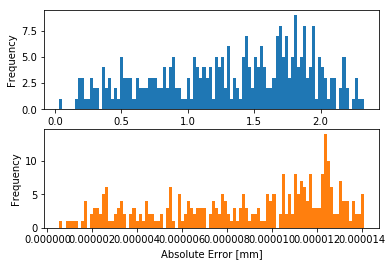

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2,1)

axes[0].hist(
    x=nominal_errors,
    color='C0',
    bins=100
);
axes[0].set_ylabel('Frequency');

axes[1].hist(
    x=calibrated_errors,
    color='C1',
    bins=100
);
axes[1].set_xlabel('Absolute Error [mm]');
axes[1].set_ylabel('Frequency');